In [ ]:
!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [54]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import timedelta
from io import BytesIO
import base64
import pickle

# to get the help functions add at path system
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LEVX_1km')
#import help_functions

def get_metar(oaci,control):
     """
     get metar from IOWA university database
     
     in: OACI airport code
     Returns
      -------
     dataframe with raw metar.
     """
     #today metar control =True
     if control:
       today = pd.to_datetime("today")+timedelta(1)
       yes = today-timedelta(1)
     else:
        today = pd.to_datetime("today")+timedelta(1)
        yes = today-timedelta(2)

     #url string
     s1="https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station="
     s2="&data=all"
     s3="&year1="+yes.strftime("%Y")+"&month1="+yes.strftime("%m")+"&day1="+yes.strftime("%d")
     s4="&year2="+today.strftime("%Y")+"&month2="+today.strftime("%m")+"&day2="+today.strftime("%d")
     s5="&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2"
     url=s1+oaci+s2+s3+s4+s5
     df_metar_global=pd.read_csv(url,parse_dates=["valid"],).rename({"valid":"time"},axis=1)
     df_metar = df_metar_global[["time",'tmpf', 'dwpf','drct', 'sknt', 'alti','vsby',
                                 'gust', 'skyc1', 'skyc2', 'skyl1', 'skyl2','wxcodes',
                                 "metar"]].set_index("time")
     
     #temperature dry a dew point to celsius                            
     df_metar["temp_o"] = np.rint((df_metar.tmpf - 32)*5/9)
     df_metar["tempd_o"] = np.rint((df_metar.dwpf - 32)*5/9)

     #QNH to mb
     df_metar["mslp_o"] = np.rint(df_metar.alti*33.8638)

     #visibility SM to meters
     df_metar["visibility_o"] =np.rint(df_metar.vsby/0.00062137)

     #wind direction, intensity and gust
     df_metar["spd_o"] = df_metar["sknt"]
     df_metar["dir_o"] = df_metar["drct"]
     df_metar['gust_o'] = df_metar['gust'] 

     #Add suffix cloud cover and cloud height, present weather, and metar 
     df_metar['skyc1_o'] = df_metar['skyc1']
     df_metar["skyl1_o"] = df_metar["skyl1"]
     df_metar['skyc2_o'] = df_metar['skyc2']
     df_metar["skyl2_o"] = df_metar["skyl2"]
     df_metar["wxcodes_o"] = df_metar["wxcodes"]
     df_metar["metar_o"] = df_metar["metar"]
     

     # Select all columns that do not start with "_o"
     columns_to_keep = [col for col in df_metar.columns if col.endswith("_o")]
     df_metar = df_metar[columns_to_keep] 

     return df_metar 



  
def get_meteogalicia_model_1Km(coorde):
    """
    get meteogalicia model (1Km)from algo coordenates
    Returns
    -------
    dataframe with meteeorological variables forecasted.
    """
    
    #defining url to get model from Meteogalicia server
    #today = C
    #today = pd.to_datetime("today")+timedelta(1)
    today = pd.to_datetime("today")

    try:

      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control = True
    except:

      today = pd.to_datetime("today")-timedelta(1)
      head1 = "http://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3
  
      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3
  
      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d") 
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"
  
      dffinal=pd.DataFrame() 
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)    
  
      
      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')
  
      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})
  
      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])  
      control= False  

     
    return dffinal , control


# Set the directory you want to list algorithms filenames from
algo_dir = '/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/'

#get meteorological model from algorithm file. Select "coor" key to get coordinates. Pick up first algorithm all same coordinates
meteo_model,con = get_meteogalicia_model_1Km(pickle.load(open(algo_dir+os.listdir(algo_dir)[0],"rb"))["coor"])

#add time variables
meteo_model["hour"] = meteo_model.index.hour
meteo_model["month"] = meteo_model.index.month
meteo_model["dayofyear"] = meteo_model.index.dayofyear
meteo_model["weekofyear"] = meteo_model.index.weekofyear

#show meteorological model and control variable. Control variable True if Day analysis = today 
print("Day analysis = today :",con)
meteo_model.info()


metars = get_metar("LEVX",con)
metars

<ipython-input-54-e05a8a51b445>:165: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  meteo_model["weekofyear"] = meteo_model.index.weekofyear


Day analysis = today : True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 2022-12-23 01:00:00 to 2022-12-25 23:00:00
Freq: H
Data columns (total 54 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dir0         71 non-null     float64
 1   mod0         71 non-null     float64
 2   wind_gust0   71 non-null     float64
 3   mslp0        71 non-null     float64
 4   temp0        71 non-null     float64
 5   rh0          71 non-null     float64
 6   visibility0  71 non-null     float64
 7   lhflx0       71 non-null     float64
 8   lwflx0       71 non-null     float64
 9   conv_prec0   71 non-null     float64
 10  prec0        71 non-null     float64
 11  swflx0       71 non-null     float64
 12  shflx0       71 non-null     float64
 13  cape0        71 non-null     float64
 14  cin0         71 non-null     float64
 15  cfh0         71 non-null     float64
 16  T8500        71 non-null     float64
 17  cfl0         71 non-

,temp_o,tempd_o,mslp_o,visibility_o,spd_o,dir_o,gust_o,skyc1_o,skyl1_o,skyc2_o,skyl2_o,wxcodes_o,metar_o
time,,,,,,,,,,,,,
2022-12-23 00:00:00,14.0,13.0,1023.0,7998.0,8.0,170.0,M,FEW,200.0,BKN,400.00,M,LEVX 230000Z 17008KT 080V230 8000 FEW002 BKN00...
2022-12-23 00:30:00,14.0,13.0,1023.0,8996.0,9.0,170.0,M,SCT,600.0,BKN,900.00,M,LEVX 230030Z 17009KT 100V220 9000 SCT006 BKN00...
2022-12-23 01:00:00,13.0,13.0,1023.0,9994.0,9.0,180.0,M,FEW,500.0,SCT,700.00,M,LEVX 230100Z 18009KT 140V220 9999 FEW005 SCT00...
2022-12-23 01:30:00,14.0,13.0,1023.0,9994.0,8.0,180.0,M,FEW,500.0,BKN,1000.00,M,LEVX 230130Z 18008KT 140V210 9999 FEW005 BKN01...
2022-12-23 02:00:00,13.0,13.0,1023.0,9994.0,8.0,170.0,M,FEW,400.0,BKN,1000.00,M,LEVX 230200Z 17008KT 120V210 9999 FEW004 BKN01...
2022-12-23 02:30:00,13.0,13.0,1023.0,9994.0,10.0,160.0,M,SCT,300.0,BKN,600.00,M,LEVX 230230Z 16010KT 100V210 9999 SCT003 BKN00...
2022-12-23 03:00:00,14.0,13.0,1023.0,9994.0,14.0,190.0,M,FEW,300.0,BKN,800.00,M,LEVX 230300Z 19014KT 140V230 9999 FEW003 BKN00...
2022-12-23 03:30:00,14.0,13.0,1022.0,9994.0,10.0,180.0,M,FEW,200.0,SCT,300.00,M,LEVX 230330Z 18010KT 110V220 9999 FEW002 SCT00...
2022-12-23 04:00:00,14.0,13.0,1022.0,2398.0,14.0,200.0,M,FEW,100.0,SCT,700.00,RA BCFG,LEVX 230400Z 20014KT 150V230 2400 RA BCFG FEW0...


***Wind intensity knots***
Reference (48 hours) Median absolute error Meteorological Model: 1.04
Reference (48 hours) Median absolute error Machine learning: 0.75

Median absolute error meteorological model 6.0
Median absolute error machine learning 3.0

                      spd_ml  spd_o  spd_WRF
time                                       
2022-12-23 00:00:00     NaN    8.0      NaN
2022-12-23 00:30:00     NaN    9.0      NaN
2022-12-23 01:00:00     9.0    9.0      7.0
2022-12-23 01:30:00     NaN    8.0      NaN
2022-12-23 02:00:00    11.0    8.0     11.0
2022-12-23 02:30:00     NaN   10.0      NaN
2022-12-23 03:00:00    11.0   14.0     13.0
2022-12-23 03:30:00     NaN   10.0      NaN
2022-12-23 04:00:00    11.0   14.0     15.0
2022-12-23 04:30:00     NaN   10.0      NaN
2022-12-23 05:00:00    13.0   10.0     17.0
2022-12-23 05:21:00     NaN    8.0      NaN
2022-12-23 05:30:00     NaN    8.0      NaN
2022-12-23 06:00:00    13.0   10.0     17.0
2022-12-23 06:30:00     NaN   10.0      

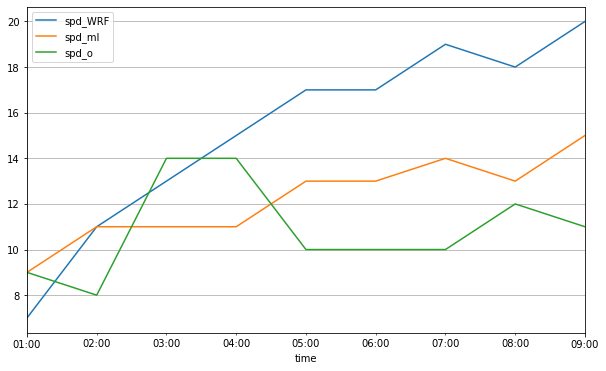

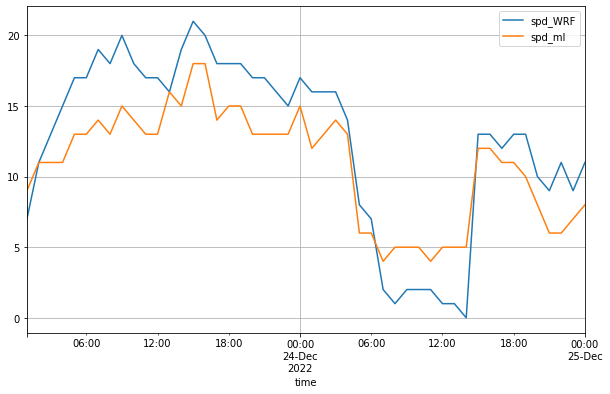

In [55]:
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/spd_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
spd_ml = alg["pipe"].predict(meteo_model[:24][alg["x_var"]])
spd_ml1 = alg1["pipe"].predict(meteo_model[24:48][alg1["x_var"]])

df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "spd_WRF": np.concatenate((np.rint(model_x_var["mod0"]*1.94384),
                                                   np.rint(model_x_var1["mod0"]*1.94384)),axis=0),
                       "spd_ml": np.concatenate((np.rint(spd_ml*1.94384),
                                                  np.rint(spd_ml1*1.94384)),axis =0),})
df_for = df_for.set_index("time")

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars["spd_o"]],axis = 1)

#get mae
df_res_dropna = df_res.dropna()
mae_ml = median_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_ml)
mae_wrf = median_absolute_error(df_res_dropna.spd_o,df_res_dropna.spd_WRF)

#print results
print("***Wind intensity knots***")
print("Reference (48 hours) Median absolute error Meteorological Model: 1.04")
print("Reference (48 hours) Median absolute error Machine learning: 0.75")
print("\nMedian absolute error meteorological model",round(mae_wrf,2))
print("Median absolute error machine learning",round(mae_ml,2))
print("\n",df_res[["spd_ml","spd_o","spd_WRF"]])

#show results
df_res.dropna().plot(grid=True,figsize=(10,6));
df_for.plot(grid=True,figsize=(10,6));

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


***Wind direction***
Reference (48 hours) Accuracy Meteorological Model: 0.20
Reference (48 hours) Accuracy Machine learning: 0.41

Accuracy meteorological model 0.22
Accuracy machine learning 0.22

                          dir_ml     dir_o_l   dir_WRF_l
time                                                   
2022-12-23 00:00:00         NaN  (160, 180]         NaN
2022-12-23 00:30:00         NaN  (160, 180]         NaN
2022-12-23 01:00:00  (180, 200]  (160, 180]  (120, 140]
2022-12-23 01:30:00         NaN  (160, 180]         NaN
2022-12-23 02:00:00  (180, 200]  (160, 180]  (180, 200]
2022-12-23 02:30:00         NaN  (140, 160]         NaN
2022-12-23 03:00:00  (180, 200]  (180, 200]  (180, 200]
2022-12-23 03:30:00         NaN  (160, 180]         NaN
2022-12-23 04:00:00  (180, 200]  (180, 200]  (180, 200]
2022-12-23 04:30:00         NaN  (160, 180]         NaN
2022-12-23 05:00:00  (180, 200]  (160, 180]  (200, 220]
2022-12-23 05:21:00         NaN  (160, 180]         NaN
2022-12-23 05:30

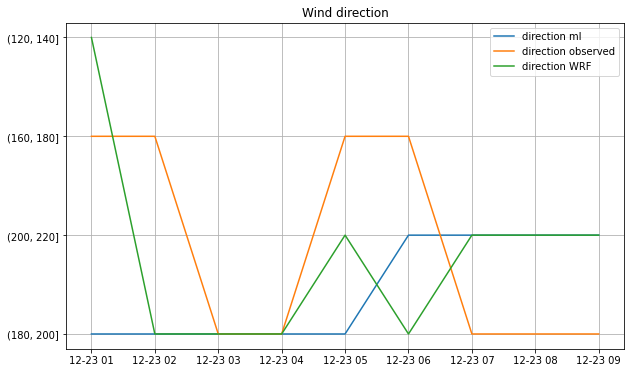

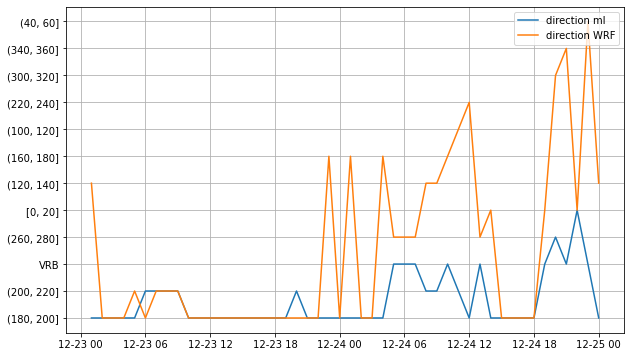

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/dir_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
dir_ml = alg["pipe"].predict(model_x_var)
dir_ml1 = alg1["pipe"].predict(model_x_var1)

#set up dataframe forecast machine learning and WRF
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                        "dir_WRF": np.concatenate((model_x_var["dir0"],model_x_var1["dir0"]),axis=0),
                        "dir_ml": np.concatenate((dir_ml,dir_ml1),axis =0),})
df_for = df_for.set_index("time")

#label dir_o and dir0 .wind direction to interval dir=-1 variable wind
interval = pd.IntervalIndex.from_tuples([(-1.5, -0.5),(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])

labels = ['VRB', '[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]',
          '(100, 120]', '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]',
          '(200, 220]','(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]',
          '(300, 320]', '(320, 340]', '(340, 360]']

df_for["dir_WRF_l"] = pd.cut(df_for["dir_WRF"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)

#dir_o to intervals 
metars["dir_o_l"] = pd.cut(metars["dir_o"].replace("M",-1).astype(float), bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)                    

#metar versus forecast
# set the max columns to none
pd.set_option('display.max_rows', 100)

# concat metars an forecast
df_res = pd.concat([df_for,metars[["dir_o","dir_o_l"]]],axis = 1)

#get accuracy
df_res_dropna = df_res.dropna()
acc_ml = accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_ml)
acc_wrf = accuracy_score(df_res_dropna.dir_o_l,df_res_dropna.dir_WRF_l)

#print results
print("***Wind direction***")
print("Reference (48 hours) Accuracy Meteorological Model: 0.20")
print("Reference (48 hours) Accuracy Machine learning: 0.41")
print("\nAccuracy meteorological model",round(acc_wrf,2))
print("Accuracy machine learning",round(acc_ml,2))
print("\n",df_res[["dir_ml","dir_o_l","dir_WRF_l"]])

#show results
plt.figure(figsize=(10, 6))
plt.plot(df_res_dropna.index, df_res_dropna['dir_ml']);
plt.plot(df_res_dropna.index, df_res_dropna['dir_o_l']);
plt.plot(df_res_dropna.index, df_res_dropna['dir_WRF_l']);

plt.legend(('direction ml', 'direction observed', 'direction WRF'),
           loc='upper right')
plt.title('Wind direction')
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df_for.index, df_for['dir_ml']);
plt.plot(df_for.index, df_for['dir_WRF_l']);
plt.legend(('direction ml','direction WRF'),
           loc='upper right')
plt.grid(True)
plt.show()


In [65]:
#open algorithm spd d0 d1
alg = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d0.al","rb"))
alg1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/LEVX_1km/algorithms/gust_LEVX_1km_time_d1.al","rb"))

#select model variables
model_x_var = meteo_model[:24][alg["x_var"]]
model_x_var1 = meteo_model[24:48][alg1["x_var"]]

# forecat spd from ml
gust_ml = alg["pipe"].predict(model_x_var)
gust_ml1 = alg1["pipe"].predict(model_x_var1)

#label metars gust data
metars["gust_o_l"] = ["No Gust" if c=="M" else "Gust" for c in metars.gust_o]

#set up dataframe forecast machine learning 
df_for = pd.DataFrame({"time":meteo_model[:48].index,
                       "gust_ml": np.concatenate((gust_ml,gust_ml1),axis =0),})
df_for = df_for.set_index("time")

# concat metars an forecast
df_res = pd.concat([df_for,metars["gust_o_l"]], axis = 1)

#Heidke skill score
cm = pd.crosstab(df_res.dropna().gust_o_l, df_res.dropna().gust_ml, margins=True,)

if cm.shape == (3,3):# complete confusion matrix to calculate HSS
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS = 2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))
  print("\nReference (48 hours) Heidke skill Score: 0.42")

print("Confusion matrix\n")
print(cm)

print(df_res)

Confusion matrix

gust_ml   No Gust  All
gust_o_l              
Gust            1    1
No Gust         8    8
All             9    9
                     gust_ml gust_o_l
time                                 
2022-12-23 00:00:00      NaN  No Gust
2022-12-23 00:30:00      NaN  No Gust
2022-12-23 01:00:00  No Gust  No Gust
2022-12-23 01:30:00      NaN  No Gust
2022-12-23 02:00:00  No Gust  No Gust
2022-12-23 02:30:00      NaN  No Gust
2022-12-23 03:00:00  No Gust  No Gust
2022-12-23 03:30:00      NaN  No Gust
2022-12-23 04:00:00  No Gust  No Gust
2022-12-23 04:30:00      NaN  No Gust
2022-12-23 05:00:00  No Gust  No Gust
2022-12-23 05:21:00      NaN  No Gust
2022-12-23 05:30:00      NaN  No Gust
2022-12-23 06:00:00  No Gust  No Gust
2022-12-23 06:30:00      NaN  No Gust
2022-12-23 07:00:00  No Gust  No Gust
2022-12-23 07:30:00      NaN     Gust
2022-12-23 08:00:00  No Gust  No Gust
2022-12-23 08:30:00      NaN  No Gust
2022-12-23 09:00:00  No Gust     Gust
2022-12-23 09:30:00      NaN  N